In [188]:
import numpy as np
import keras
import random
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import random
import cv2
from scipy import ndimage
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.backend as K

In [14]:
path = "D:/downloads/train/"
path_seis = os.path.join(path,'seis')
path_fault = os.path.join(path,'fault')
validation_path = "D:/downloads/validation/"
validation_seis = os.path.join(validation_path,'seis')
validation_fault = os.path.join(validation_path,'fault')

In [15]:
def get_data(seis_path, fault_path):
    seis_names = os.listdir(seis_path)
    fault_names = os.listdir(fault_path)
    X = []
    Y = []
    for i in range(len(seis_names)):
        seis_cube = np.fromfile(os.path.join(seis_path, seis_names[i]),dtype=np.single)
        faults = np.fromfile(os.path.join(fault_path, fault_names[i]),dtype=np.single)
        dim = (128,128,128)
        seis_cube = np.reshape(seis_cube, dim)
        fault = np.reshape(faults, dim)
        seis_m = np.mean(seis_cube)
        seis_sigma = np.std(seis_cube)
        seis_cube_norm = (seis_cube-seis_m)/seis_sigma
        x = np.reshape(seis_cube_norm,(1,128,128,128,1))
        y =  np.reshape(fault,(1,128,128,128,1))
        #seis_cube_norm = np.transpose(seis_cube_norm)
        #fault = np.transpose(fault)

        for k in range(128):
            X.append(np.transpose(x[0,k,:,:,0]))
            X.append(np.transpose(x[0,:,k,:,0]))
            Y.append(np.transpose(y[0,k,:,:,0]))
            Y.append(np.transpose(y[0,:,k,:,0]))
    X = np.array(X)
    Y = np.array(Y)
    X = X/255.0
    return X,Y
    

In [16]:
dataset, target = get_data(path_seis, path_fault)
print(dataset.shape)
validation_x, validation_y = get_data(validation_seis, validation_fault)
print(validation_x.shape)

(51200, 128, 128)
(5120, 128, 128)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(dataset, target, random_state=4)
print(x_train.shape, x_test.shape)

(38400, 128, 128) (12800, 128, 128)


# Data visualisation

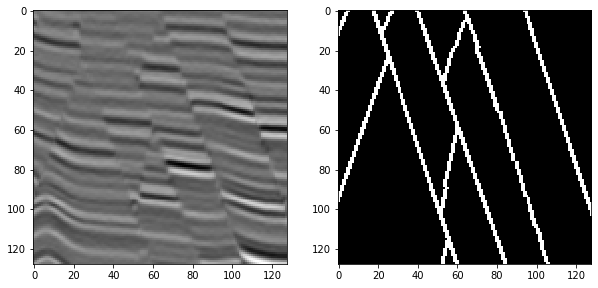

In [18]:
seis_cube = x_train[10]
faults = y_train[10]
fig = plt.figure(figsize=(10,10))
k1 = 5
plt.subplot(1, 2, 1)
imgplot1 = plt.imshow(seis_cube,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
imgplot2 = plt.imshow(faults,interpolation='nearest',aspect=1,cmap=plt.cm.gray)

In [71]:
def rotation(pair,angle):
    #print("rotation at angle ",angle)
    pair[0] = ndimage.rotate(pair[0], angle) 
    pair[1] = ndimage.rotate(pair[1], angle)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    #pair[1] = pair[1].reshape((128,128))
    return pair

def blur(pair):
    kernel = (random.randint(1,10), random.randint(1,5))
    pair[0] = cv2.blur(pair[0], kernel)
    pair[1] = cv2.blur(pair[1], kernel)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair

def flip(pair):
    flip = random.randint(-1,1)
    pair[0] = cv2.flip(pair[0], flip)
    pair[1] = cv2.flip(pair[1], flip)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair
    
def augmentations(pair, type_of_augmentation):
    cases = {
        '1': lambda pair: rotation(pair, random.choice(90, 180, 270, 360)),
        '2': lambda pair: blur(pair),
        '3': lambda pair: flip(pair)
    }
    result = cases[str(type_of_augmentation)]
    return result(pair)



In [20]:
def augmentation(quantity, X, Y):
    pairs = [[X[i], Y[i]] for i in range(quantity)]
    x_augmented = pairs
    for i, pair in enumerate(pairs):
        x_augmented[i] = augmentations(pair, random.randint(1,3))
    x_augmented = np.array(x_augmented)
    return x_augmented

In [21]:
x_augmented = augmentation(250, x_train, y_train)
# np.append(x_train_augmented,x_train)   
# np.append(y_train,y_train)
#print(X.shape, x_augmented[0].shape)
x_train = np.append(x_train, x_augmented[:,0],axis=0)
y_train = np.append(y_train, x_augmented[:,1],axis=0)

In [222]:
def cross_entropy_balanced(y_true, y_pred):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    # Keras expects probabilities.
    # transform y_pred back to logits
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.math.log(y_pred/ (1 - y_pred))

    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)
    beta = count_neg / (count_neg + count_pos)
    pos_weight =- beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(y_pred, y_true, pos_weight=pos_weight)
    cost = tf.reduce_mean(cost * (1 - beta))
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)


def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

In [223]:
def unet(input_size = (None,None,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    pool3 = Dropout(0.5)(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, 3, activation='relu', padding='same')(conv7)
    
    conv7 = Dropout(0.5)(conv7)
    
    conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])
    model.summary()
    return model

In [224]:
model = unet(input_size=(None, None, 1))
model.compile(optimizer=Adam(lr=1e-3), loss=cross_entropy_balanced(), 
            metrics=['accuracy'])
model.summary()

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_269 (Conv2D)             (None, None, None, 1 160         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_270 (Conv2D)             (None, None, None, 1 2320        conv2d_269[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_54 (MaxPooling2D) (None, None, None, 1 0           conv2d_270[0][0]                 
______________________________________________________________________________________

# Model fit

In [225]:
log_dir = "logs/2dseg/" + "balanced"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x = x_train,y=y_train, epochs=5, batch_size=64, validation_data = (validation_x, validation_y),
        callbacks=[tensorboard_callback] )
model.save_weights('weights_balanced.h5')

Epoch 1/5
 85/604 [===>..........................] - ETA: 59:42 - loss: -9.6040 - accuracy: 0.0752


KeyboardInterrupt



In [ ]:
print(x_test.shape)
x_test[0].reshape(128,128,1)
y = model.predict(x_test)
print(y[0].shape)

0.68


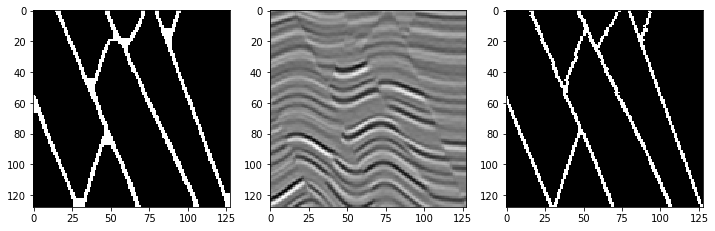

In [183]:
#mask = y[900].reshape(128,128)
k = 900
mask = y[k]
kernel = np.ones((5,5), np.uint8)
mask = np.around((mask) * 255).astype(np.uint8)
nothing, mask = cv2.threshold(mask, 110, 255, cv2.THRESH_BINARY)
mask = cv2.dilate(mask, np.ones((5,5), np.uint8), iterations = 1)
mask = cv2.erode(mask, kernel, iterations = 1)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
imgplot1 = plt.imshow(mask,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
plt.subplot(1,3,2)
imgplot2 = plt.imshow(x_test[k],interpolation='nearest',aspect=1,cmap=plt.cm.gray)
mask_test = y_test[k]#.reshape(128,128)
plt.subplot(1,3,3)
imgplot3 = plt.imshow(mask_test,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
intersection = np.logical_and(mask_test, mask)
union = np.logical_or(mask_test, mask)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

In [180]:
iou = []
for i in range(y.shape[0]):
    target = y_test[i]
    prediction = y[i]
    prediction = np.around((prediction) * 255).astype(np.uint8)
    x, prediction = cv2.threshold(prediction, 110, 255, cv2.THRESH_BINARY)
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    iou.append(iou_score)
    print(iou_score)

0.5072920772566023
0.5290023201856149
0.2647907647907648
0.7184730743012951
0.24611223799864773
0.3780630105017503
0.6515450361604208
0.5123028391167193
0.6501095690284879
0.3317278747742324
0.5827389443651926
0.16457286432160803
0.5942219304005253
0.7020648967551623
0.4769560557341908
0.7206840390879479
0.7485604606525912
0.7096378146101903
0.5794344473007712
0.5275391611925214
0.7857142857142857
0.5965865011636928
0.6583806818181818
0.5236439499304589
0.48011363636363635
0.17644032921810698
0.42748618784530384
0.6099447513812155
0.6426043878273178
0.6819672131147541
0.5797101449275363
0.5954088952654233
0.6706746826987308
0.708714198659354
0.6617210682492581
0.5653089887640449
0.59978009895547
0.6768631813125695
0.6901152213462705
0.4748051948051948
0.6326935804103243
0.5669240669240669
0.6122215876641919
0.6865284974093264
0.5549964054636952
0.514571190674438
0.704983388704319
0.6546233925290875
0.6990595611285266
0.724009900990099
0.6982248520710059
0.5442857142857143
0.49620637329

C:\Users\Sizov\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':



0.40350877192982454
0.822754491017964
0.5016857720836143
0.6026365348399246
0.7282608695652174
0.7054216867469879
0.598145285935085
0.5621237000547346
0.52046783625731
0.6539074960127592
0.500578034682081
0.568724279835391
0.385233918128655
0.751696065128901
0.47947214076246336
0.6846264367816092
0.7191011235955056
0.7295208655332303
0.7352941176470589
0.5987892129884425
0.6124641833810889
0.708984375
0.5242798353909465
0.7215874924834637
0.638758231420508
0.6683861459100958
0.2616377845735644
0.2077814569536424
0.7362055933484505
0.6227876106194691
0.6321339950372209
0.5676855895196506
0.6910866910866911
0.565677966101695
0.5007194244604316
0.4452773613193403
0.5068997240110396
0.6076861489191353
0.41858090862685043
0.16271186440677965
0.6508226691042047
0.685086155674391
0.5859323158593231
0.6373626373626373
0.361260568793236
0.7168458781362007
0.6294608959757023
0.25391849529780564
0.6545988258317026
0.7032163742690059
0.1111111111111111
0.46741573033707867
0.20602605863192183
0.61

0.7211538461538461
0.38549075391180654
0.5790229885057471
0.5479876160990712
0.41125541125541126
0.4444444444444444
0.5191570881226054
0.6625698324022347
0.7902813299232737
0.0
0.15440689198144467
0.41018619934282585
0.5862068965517241
0.3855633802816901
0.75022143489814
0.7473251028806585
0.4641025641025641
0.5757162346521146
0.470873786407767
0.6838755304101839
0.5836298932384342
0.6818181818181818
0.7284325637910085
0.570185614849188
0.47061545580749653
0.5933997509339975
0.6049488054607508
0.18730886850152906
0.4056291390728477
0.7562724014336918
0.35505430242272346
0.6006739679865206
0.7061488673139159
0.5592485549132948
0.3984496124031008
0.6201157742402316
0.5555555555555556
0.6747049769112365
0.29439252336448596
0.5043196544276458
0.5764895330112721
0.0771478667445938
0.6144096064042696
0.6899275839368005
0.7056798623063684
0.6666666666666666
0.5969563082965145
0.5034146341463415
0.5953820780648708
0.6633358954650269
0.48050314465408805
0.5633528265107213
0.526686807653575
0.34

0.5228821811100293
0.6430722891566265
0.654320987654321
0.6575342465753424
0.5606316976875353
0.6855151045701007
0.5390578413834228
0.6426982950333581
0.47962555066079293
0.6601836844948676
0.6675603217158177
0.6590141796083727
0.5847076461769115
0.6243315508021391
0.3216
0.5585253456221199
0.6010143702451395
0.7005988023952096
0.5713213213213213
0.6602687140115163
0.8231780167264038
0.5985060690943044
0.6942735447231424
0.6733780760626398
0.5502063273727648
0.6130329847144006
0.187973086627418
0.6970074812967582
0.7271767810026385
0.5691823899371069
0.693672383205204
0.6736596736596736
0.5583941605839416
0.16705882352941176
0.658256880733945
0.7323943661971831
0.7055045871559633
0.6480067854113656
0.6879831342234716
0.7164461247637051
0.6505208333333333
0.5465787304204451
0.5950854700854701
0.4834080717488789
0.7412974683544303
0.379415347137637
0.601581508515815
0.629156010230179
0.5639763779527559
0.3899876390605686
0.6369047619047619
0.53984375
0.3297442799461642
0.6170634920634921

0.7838565022421524
0.5957446808510638
0.5347938144329897
0.28618638466622603
0.35598980458793544
0.5266075388026608
0.7477558348294434
0.4929889298892989
0.7034013605442176
0.6629542790152403
0.7349746560463433
0.7807424593967517
0.518005540166205
0.43859649122807015
0.5358649789029536
0.5627009646302251
0.6734939759036145
0.6188257222739981
0.6532634032634033
0.703551912568306
0.7580201649862511
0.5706161137440758
0.7211714460036608
0.625
0.45235975066785394
0.43740095087163233
0.5422647527910686
0.7220101781170484
0.5634469696969697
0.6141618497109826
0.6598425196850394
0.3966512702078522
0.7214870825456837
0.6107011070110702
0.3333333333333333
0.22425127830533237
0.5094650205761316
0.5370689655172414
0.6787610619469027
0.5214922952149229
0.6275051831375259
0.5797779076563413
0.49348869088416725
0.5610921501706485
0.5051628276409849
0.5607427055702918
0.1787749287749288
0.7371695178849145
0.7054574638844302
0.49906658369632856
0.4979472140762463
0.6811240073304826
0.5579710144927537


0.5888520971302428
0.5018427518427518
0.6569987389659521
0.583011583011583
0.7254716981132076
0.40063846767757383
0.5826032540675845
0.8112280701754386
0.8337628865979382
0.4641799881586738
0.1876790830945559
0.7706666666666667
0.6298600311041991
0.6796267496111975
0.6756476683937824
0.5269058295964125
0.44412607449856734
0.606516290726817
0.6337719298245614
0.6327319587628866
0.6001506024096386
0.5048216007714561
0.19189566837447602
0.6572604350382129
0.6829590488771466
0.641395908543923
0.6120857699805068
0.7738396624472574
0.524330900243309
0.28529698149951316
0.549899531145345
0.5061475409836066
0.674690007293946
0.646218487394958
0.3452157598499062
0.5096774193548387
0.7939024390243903
0.5222381635581061
0.5919003115264797
0.24551910720324654
0.5764649833253931
0.3607705779334501
0.5207100591715976
0.657
0.5049115913555993
0.332588287885561
0.47708489857250186
0.6325237592397043
0.6256239600665557
0.7070938215102975
0.5143066764490095
0.6234612599565532
0.586171310629515
0.3219455

0.6106382978723405
0.6434378629500581
0.6212349397590361
0.7052868391451068
0.6442105263157895
0.4921689606074988
0.6978832584990379
0.6065029860650298
0.5731303772336201
0.7363515312916112
0.6390293225480284
0.5265588914549654
0.6642066420664207
0.5969551282051282
0.51796875
0.6322314049586777
0.25384615384615383
0.6536502546689303
0.6220036877688998
0.21811594202898552
0.43887775551102204
0.7197674418604652
0.5984812529663028
0.5506807866868382
0.7772511848341233
0.7716346153846154
0.6153846153846154
0.7136699507389163
0.6450967311541027
0.5888429752066116
0.7087517934002869
0.673572228443449
0.6206425153793574
0.6574882471457354
0.5594671741198858
0.6115760111576011
0.7382012466607302
0.741423125794155
0.3252885624344176
0.648014440433213
0.3670647391577624
0.6123456790123457
0.7333732774116237
0.7253012048192771
0.6861471861471862
0.33102012491325467
0.6296515062020083
0.5377599416271434
0.6963824289405685
0.5693323550990462
0.5837765957446809
0.5226917057902973
0.45535714285714285

0.751937984496124
0.7218934911242604
0.5789825970548862
0.37017033651848774
0.7292110874200426
0.4086629001883239
nan
0.8175438596491228
0.32826409495548964
0.4956772334293948
0.6557377049180327
0.5411347517730496
0.15276932440657334
0.7274401473296501
0.5
0.5617628801986344
0.5498220640569395
0.2740740740740741
0.6230558096980787
0.5731225296442688
0.5554156171284634
0.7066854990583804
0.43316412859560066
0.19031607262945527
0.6504653567735263
0.49572649572649574
0.8411405295315683
0.5837638376383764
0.10386473429951691
nan
nan
0.6001313197636244
0.6572769953051644
0.6655124653739612
0.7217272104180946
0.7876787678767877
0.7043859649122807
0.6638513513513513
0.7024848891873741
0.6889020070838253
0.6775738228252195
0.8017324350336862
0.6438106796116505
0.6062874251497006
0.3394131641554322
0.7442680776014109
0.5932475884244373
0.6358479863868406
0.5912187736563209
0.4226666666666667
0.47012345679012346
0.5513725490196079
0.5501373626373627
0.5252808988764045
0.7230246389124894
0.621079

0.7177197802197802
0.483467381590706
0.6413390010626993
0.6460626587637596
0.10255018990775909
0.743231441048035
0.5406078724464375
0.5886571056062582
0.48139711465451784
0.45821325648414984
0.5176651305683564
0.7316901408450704
0.13717128642501777
0.32581967213114754
0.4007434944237918
0.6158680282796544
0.8109243697478992
0.40286975717439294
0.4887039239001189
0.6310272536687631
0.1771948608137045
0.6266986410871302
0.39384220654265556
0.6387614678899083
0.7111984282907662
0.5214395099540582
0.4345825115055884
0.4378029079159935
0.7691309987029832
0.3744493392070485
0.3834296724470135
0.8052884615384616
0.7297777777777777
0.4366312346688471
0.6523668639053254
0.4943181818181818
0.5517826825127334
0.5082926829268293
0.5647249190938511
0.2699896157840083
0.6740331491712708
0.5257315842583249
0.652766639935846
0.5032410135533294
0.7115507338864071
0.3760198652004257
nan
0.7369774919614148
0.41008403361344536
0.6212121212121212
0.6397008837525493
0.6877710320901995
0.8356687898089172
0.5

0.7188723570869224
0.6957142857142857
0.5645161290322581
0.5097142857142857
0.487467018469657
0.7096594081518705
0.44673539518900346
0.5956896551724138
0.5952380952380952
0.3811881188118812
0.5613756613756614
0.609254498714653
0.570254110612855
0.5886363636363636
0.2266260162601626
0.6814106395696354
0.6503667481662592
0.6205035971223022
0.6827896512935883
0.5221540558963872
0.4914772727272727
0.47742387119355967
0.49255952380952384
0.6673785371062466
0.768790264853257
0.513493800145879
0.6450853443201884
0.7095205003474635
0.5721362229102167
0.6013810420590081
0.5993527508090615
0.739101717305152
0.8030018761726079
0.6561743341404358
0.5464743589743589
0.7204997686256362
0.7962962962962963
0.5778210116731517
0.31911013858497445
0.687013764213046
0.6996763754045308
0.6519434628975265
0.7002360346184107
0.0
0.6759474091260634
0.0
0.5464285714285714
0.6074709124311084
0.6963078523140925
0.4909090909090909
0.6451612903225806
0.6866359447004609
0.6051682692307693
0.5909863945578231
0.61812

0.7281443880428652
0.741514360313316
0.7272727272727273
0.7304730473047305
0.5241336633663366
0.6340057636887608
0.6777142857142857
0.5630026809651475
0.37797619047619047
0.0
0.6186342592592593
0.4373259052924791
0.5982431807674526
0.28298017771701983
0.3292797006548176
0.4345887016848365
0.6446850393700787
0.8262757871878393
0.48370672097759676
0.5861386138613861
0.6753022452504318
0.5486725663716814
0.5892045454545455
0.6243936243936244
0.223267750213858
0.75
0.6078234704112337
0.7376664056382146
0.5589928057553957
0.32432432432432434
0.6681096681096681
0.3642415596766524
0.5936811168258633
0.5978120978120978
0.46148092744951386
0.5695431472081218
0.7109311740890688
0.22505800464037123
0.3464052287581699
0.7032558139534884
0.7303070761014686
0.6607301869991096
0.4535875564475665
0.65
0.5738950276243094
0.5685279187817259
0.5232843137254902
0.7382198952879581
0.4057796508127634
0.5364705882352941
0.6733800350262698
0.17763483424047502
0.6173469387755102
0.8048
0.47619047619047616
0.41

0.46741573033707867
0.6380728554641598
0.6353691886964449
0.5264813843733613
0.4372937293729373
0.39733542319749215
0.5777777777777777
0.6699029126213593
0.19220055710306408
0.5118043844856661
0.7301204819277108
0.38438735177865613
0.5572390572390572
0.5779889152810768
0.6838983050847458
0.16721672167216722
0.5148514851485149
0.5021897810218978
0.3608374384236453
0.5341098169717138
0.0
0.7395751376868608
0.4819672131147541
0.6563231850117096
0.4523809523809524
0.36694677871148457
0.6482213438735178
0.5978428351309707
0.7288503253796096
0.20934959349593496
0.5621657754010695
0.6025437201907791
0.6487000634115409
0.5176548967355097
0.7130339539978094
0.15384615384615385
0.7177798682972719
0.5502450980392157
0.3861788617886179
0.552393857271906
0.6780072904009721
0.7214022140221402
0.5129604365620737
0.4070155902004454
0.4635157545605307
0.6935146443514645
0.7341897233201581
0.4737762237762238
0.530316742081448
0.7145938173975557
0.4647809206877426
0.40218049666868566
0.42360655737704916


0.3727524204702628
0.46646341463414637
0.6261127596439169
0.6170091324200914
0.19440914866581957
0.4697754749568221
0.4288179465056083
0.3759197324414716
0.5360065466448445
0.7455470737913485
0.5072604065827686
0.5933838731909028
0.6124794745484401
0.5211360634081902
0.7310734463276836
0.5219556360344048
0.4072208228379513
0.7042606516290727
0.2982456140350877
0.6333333333333333
0.3479648842777334
0.4400684931506849
0.5654205607476636
0.46162927981109797
0.5852754237288136
0.34416991764195926
0.4
0.5287037037037037
0.7394757744241461
0.6449438202247191
0.6396825396825396
0.5774358974358974
0.5610889774236387
0.6257505003335557
0.6566901408450704
0.6091954022988506
0.3952451708766716
0.6046221111805122
0.6514563106796116
0.6718080548414739
0.506398537477148
0.6966199505358615
0.6498842592592593
0.6826115061409179
0.306873977086743
0.5060670949321913
0.6135817307692307
0.4556135770234987
0.6005420054200542
0.15397631133671744
0.4633431085043988
0.5435897435897435
0.7269736842105263
0.612

0.43434343434343436
0.614100185528757
0.6877033181522446
0.11472602739726027
0.6483762597984323
0.5655682582380632
0.3519695044472681
0.55005382131324
0.7552650689905592
0.6491935483870968
0.6437598736176935
0.656392694063927
0.7779605263157895
0.49973390101117615
0.6599856836077308
0.5747021081576535
0.6497005988023952
0.25555007400098667
0.6711026615969582
0.6828143021914648
0.39545454545454545
0.7089005235602094
0.6600411240575736
0.5071090047393365
0.6202290076335878
0.611157368859284
0.6958677685950413
0.5613346418056918
0.6337157987643425
0.5984555984555985
0.6169513797634691
0.23317925012840268
0.22261844116148752
0.6945224719101124
0.21415094339622642
0.6650485436893204
0.611716621253406
0.2388955582232893
0.5070960698689956
0.3981308411214953
0.6146234194612424
0.6621513944223107
0.7647058823529411
0.5011914217633042
0.6647691334598356
0.5902317880794702
0.6724565756823822
0.5438931297709924
0.7775
0.4856262833675565
0.16621983914209115
0.5412587412587413
0.4835371589840075
0.

0.6084033613445378
0.5739167374681393
0.464
0.17267843438219493
0.5604395604395604
0.6875
0.6282485875706215
0.6905882352941176
0.5849889624724062
0.43037974683544306
0.7188264058679706
0.5681983953318746
0.583427922814983
0.5058479532163743
0.603967168262654
0.6664691943127962
0.4151047409040794
0.7589712918660287
0.6926829268292682
0.20408163265306123
0.6368501529051988
0.510989010989011
0.5702479338842975
0.6491017964071857
0.45904645476772615
0.6546511627906977
0.07468123861566485
0.5058139534883721
0.1630144307856761
0.5808865860679332
0.3208053691275168
0.6510500807754442
0.056155507559395246
0.26400389673648317
0.5730103806228374
0.6180631120783461
0.6530820173204279
0.40827797649463465
0.43778501628664496
0.551760939167556
0.5369609856262834
0.4691011235955056
0.5980861244019139
0.6912751677852349
0.6751298326601269
0.22467263955892489
0.595879556259905
0.6946872898453261
0.5424610051993067
0.11290322580645161
0.6700659868026395
0.703416149068323
0.7480916030534351
0.4863424383

0.07926829268292683
0.5946491670873296
0.5533822330888346
0.5705555555555556
0.2576396206533193
0.6691489361702128
0.1737704918032787
0.3808118081180812
0.6526867627785059
0.672225416906268
0.42328042328042326
0.5605749486652978
0.5568181818181818
0.449842555105713
0.2584510055626872
0.610705596107056
0.5680147058823529
0.6058252427184466
0.5549242424242424
0.5282344531808435
0.5548523206751055
0.503968253968254
0.5703389830508474
0.5379008746355685
0.6592148309705561
0.5930620413609072
0.6635647816750179
0.5909980430528375
0.6839887640449438
0.6363636363636364
0.4644688644688645
0.5583333333333333
0.6627497062279671
0.673557278208441
0.7278562259306803
0.4672268907563025
0.6018735362997658
0.5663109756097561
0.5866900175131349
0.3499095840867993
0.6797706797706797
0.40445644834571237
0.5467185761957731
0.45210280373831774
0.7264367816091954
0.5278688524590164
0.5237623762376238
0.6782258064516129
0.6446280991735537
0.5986601705237515
0.2985283812193413
0.6192109777015438
0.51843317972

0.6691729323308271
0.49078341013824883
0.6766275346851655
0.593939393939394
0.6028368794326241
0.47607301430685744
0.3942161339421613
nan
0.5098722415795587
0.014872521246458924
0.5480549199084668
0.673216885007278
0.37808951235804944
0.4740511231603408
0.5468424705065926
0.45080500894454384
0.4934640522875817
0.2520491803278688
0.6282973621103117
0.5068181818181818
0.5709090909090909
0.26633416458852865
0.601878612716763
0.5933286018452804
0.2492063492063492
0.5363864491844417
0.5163690476190477
0.6607324516785351
0.7339510258107214
0.6092920353982301
0.5036764705882353
0.745253164556962
0.6426043878273178
0.6909638554216867
0.7067879636109167
0.5460207612456748
0.6338582677165354
0.6756393001345895
0.6072974644403216
0.6402743142144638
0.5529634300126104
0.6880258899676376
0.6943143812709031
0.68213866039953
0.4105037513397642
0.5367435158501441
0.6178451178451179
0.4990476190476191
0.5607717041800643
0.6666666666666666
0.6247974068071313
0.7106563161609033
0.5396301188903567
0.41800

0.41715237302248126
0.2222222222222222
0.5408653846153846
0.7151898734177216
0.6951219512195121
0.735781990521327
0.5348837209302325
0.4106910039113429
0.8197080291970803
0.4230769230769231
0.6994249869315212
0.5926773455377574
0.7063541024059222
0.6339869281045751
0.6501901140684411
0.6277777777777778
0.31750741839762614
0.3289241622574956
0.29565602836879434
0.6106094808126411
0.6028436018957346
0.650564617314931
0.7152563310685608
0.6772300469483568
0.5621592148309705
0.37955555555555553
0.7272024729520865
0.5560420315236427
0.7557736720554272
0.4626865671641791
0.647685525349008
0.5593321407274896
0.6925587467362925
0.636685552407932
0.6057233704292527
0.6086298258894777
0.3523997370151216
0.6463944396177237
0.7207953603976802
0.5825825825825826
0.7200504413619168
0.3944636678200692
0.18668496911461907
0.4807692307692308
0.5590327169274538
0.33725490196078434
0.20257966616084977
0.22286042504307868
0.6664674237895996
0.7171411265899454
0.6447848285922684
0.4465753424657534
0.645533

0.6080674292594822
0.278125
0.6057510404842982
0.579062159214831
0.3196960841613092
0.5055292259083728
0.5847772277227723
0.6824395373291272
0.48774703557312254
0.628463476070529
0.6763076923076923
0.29466553767993225
0.5153272576636289
0.6341463414634146
nan
0.4538914323086985
0.054502369668246446
0.6970486111111112
0.6226053639846744
0.6339622641509434
0.7509881422924901
0.4791183294663573
0.6300469483568075
0.21630901287553647
0.3964165733482643
0.5881826320501343
0.6728323699421965
0.6895752895752896
0.3475524475524476
0.297191887675507
0.34385964912280703
0.5903426791277259
0.6318926974664679
0.49726177437020813
0.3683673469387755
0.5323033707865169
0.46526655896607433
0.6836327345309381
0.49213483146067416
0.48155737704918034
0.6067073170731707
0.5227272727272727
0.5834752981260647
0.5513866231647635
0.6700554528650647
0.2884250474383302
0.6567796610169492
0.5459026494146642
0.7512839325018342
0.5139765554553652
0.1567342073897497
0.60084388185654
0.7052023121387283
0.65612903225

0.7389249852333136
0.6421965317919075
0.6570247933884298
0.585941790225151
0.7031339031339031
0.6437246963562753
0.7569095477386935
0.4692556634304207
0.6930091185410334
0.6898148148148148
0.6696950032446464
0.4319571865443425
0.424190800681431
0.6295054484492875
0.6538461538461539
0.44644549763033176
0.6026604973973395
0.3569078947368421
0.6991097922848665
0.6206451612903225
0.6750369276218612
0.20191470844212359
0.3046168491194669
0.35918367346938773
0.6583679114799447
0.30060120240480964
0.5723379629629629
0.7244152046783626
0.4234113712374582
0.6910856134157105
0.2215568862275449
0.6876310272536688
0.7327469553450608
0.751578947368421
0.6049461001902346
0.5540345821325648
0.6779053084648493
0.2579425113464448
0.6352739726027398
0.48212351029252437
0.6797331109257715
0.26430976430976433
0.46392333709131905
0.5261401557285873
0.7819025522041764
0.6228287841191067
0.5972404730617609
0.6972269383135258
0.5656223539373413
0.5742444152431012
0.5923217550274223
0.6052215189873418
0.516483

0.5973416731821736
0.4936507936507937
0.4634703196347032
0.489351403678606
0.45929847782925215
0.28797190517998245
0.6234413965087282
0.472791519434629
0.49922239502332816
0.6372812920592194
0.5911083281152161
0.6493150684931507
0.6994623655913978
0.06144393241167435
0.5750841750841751
0.656072644721907
0.6871508379888268
0.47519294377067256
0.5909090909090909
0.6289566236811255
0.7626373626373626
0.7310874704491725
0.6021739130434782
0.6586564718732932
0.5302052785923753
0.6193801833260585
0.6628527841342486
0.02602905569007264
0.5647761194029851
0.6350954478707783
0.3422077922077922
0.5633187772925764
0.6591422121896162
0.31262939958592134
0.49852724594992637
0.7786941580756014
0.4740740740740741
0.6679340937896071
0.6327345309381237
0.6071657069737684
0.6405325443786982
0.33454810495626824
0.2182061579651941
0.7438249823570925
0.6515151515151515
0.5835721107927412
0.7200512491992312
0.658703071672355
0.45504587155963305
0.7633228840125392
0.6917910447761194
0.3522222222222222
0.3781

0.4574607329842932
0.7324324324324324
0.6602972399150743
0.20210526315789473
0.6622170632617528
0.5517019910083494
0.4838028169014085
0.6627565982404692
0.5673913043478261
0.6885364095169431
0.617717003567182
0.7290322580645161
0.4197707736389685
0.6228160328879754
0.5490196078431373
0.7473053892215569
0.593521421107628
0.7366984993178718
0.3886792452830189
0.6647919010123734
0.6554132712456344
0.13513513513513514
0.4719039825422804
0.0
0.6224648985959438
0.42266009852216746
0.7349943374858438
0.6575663026521061
0.6068908260689082
0.3886838868388684
0.7187312986235787
0.5351894818252126
0.6236559139784946
0.5903954802259888
0.6172520661157025
0.331267217630854
0.24101479915433405
0.0
0.7716955941255007
0.3324579831932773
0.6389891696750902
0.6359807460890493
0.3447792571829012
0.7277448071216617
0.6922535211267605
0.18095238095238095
0.5399339933993399
0.5312101910828025
0.48580199539524177
0.31028207461328483
0.406608226567768
0.4471635150166852
0.17095205003474634
0.5648038049940547


0.5561257216164208
0.7639484978540773
0.10083396512509477
0.41098901098901097
0.5341972642188625
0.4989844278943805
0.516914749661705
0.6154721274175199
0.48214285714285715
0.4931350114416476
0.6200317965023847
0.5303584491587418
0.6279863481228669
0.5493860117458622
0.6651741293532338
0.6918304033092038
0.0
0.7316770186335404
0.4012605042016807
0.6974110032362459
0.5957284515636918
0.7895734597156399
0.45288197621225984
0.7356589147286822
0.36
0.7131578947368421
0.5987825124515772
0.6684322033898306
0.47519769949676494
0.7647798742138365
0.0
0.5987193169690501
0.7089421390999415
0.5908419497784343
0.7059907834101382
0.6728650137741047
0.15512048192771086
0.5455764075067024
0.6967113276492083
0.6108108108108108
0.28735632183908044
0.5968992248062015
0.5584778959149412
0.6410256410256411
0.508495145631068
0.6273100616016427
0.5728900255754475
0.5039113428943938
0.6909090909090909
0.4116907605279698
0.7530864197530864
0.3333333333333333
0.2391005048187242
0.37678207739307534
0.1912350597

0.4478632478632479
0.4181459566074951
0.492040520984081
0.6124546553808948
0.6982116244411326
0.6807264206209724
0.6152647975077882
0.5144472361809045
0.6411446249033256
0.5766150560597971
0.5707792207792208
0.6022267206477733
0.5854037267080745
0.7058823529411765
0.65078125
0.5250869349230005
0.44024767801857584
0.29470864032150035
nan
0.6562255285826155
0.36030204962243795
0.516318887105404
0.4229055258467023
0.5587828492392808
0.6115384615384616
0.6021297192642788
0.0
0.5879967558799676
0.6967741935483871
0.7470747074707471
0.7442046362909672
0.5859133126934984
0.6760744066709429
0.5296989422294548
0.6219165085388995
0.2552011095700416
0.6191658391261172
0.5318744053282588
0.6001400560224089
0.0860566448801743
0.6036432160804021
0.6808688387635756
0.21725239616613418
0.6625222024866785
0.6034364261168385
0.6865530303030303
0.2553979025293029
0.38694638694638694
0.7446236559139785
0.7224383916990921
0.2459727385377943
0.7781000725163162
0.4592307692307692
0.6407263294422828
0.1912672

0.6367869615832363
0.7261663286004056
0.6
0.4009409304756926
0.616580310880829
0.58125
0.6929403701165182
0.5443322109988776
0.62708719851577
0.6599713055954088
0.6423274386765545
0.19244391971664698
0.31220657276995306
0.5738498789346247
0.625
0.5813253012048193
0.5688073394495413
0.20676691729323307
0.597892888498683
0.8076923076923077
0.6094464195022854
0.5758513931888545
nan
0.4970809007506255
0.6872616323417239
0.6318407960199005
0.4726027397260274
0.6469740634005764
0.6775862068965517
0.674191121143717
0.17452229299363056
0.3996200126662445
0.4621380846325167
0.6802147239263804
0.5991058122205664
0.6079223928860146
0.5376884422110553
0.6956521739130435
0.5791610284167794
0.4495230524642289
0.649624060150376
0.46662584200857316
0.6546762589928058
0.6966743119266054
0.5301542776998598
0.5475482912332839
0.5407011289364231
0.4260731319554849
0.6142723880597015
0.6367495451788963
0.43264589732338743
0.7095568606513615
0.517428350116189
0.6564207650273224
0.7588717015468608
0.71438695

0.6181150550795593
nan
0.2497536945812808
0.5042444821731749
0.5809859154929577
0.5415531335149864
0.7866379310344828
0.6283566058002148
0.44227272727272726
0.7891654465592972
0.5860331173506119
0.5851905104241553
0.5787631271878646
0.7371888726207906
0.49104859335038364
0.3051881993896236
0.696113074204947
0.4928571428571429
0.2841121495327103
0.5201511335012594
0.7111777944486122
0.5484826054774241
0.531733746130031
0.3522633744855967
0.7242178447276941
0.6329313057157839
0.7426400759734093
0.5282916213275299
0.6316818774445893
0.6738305941845765
0.711340206185567
0.6323777403035413
0.4788918205804749
0.6398268398268399
0.6236668359573387
0.7415426251691475
0.5874352331606217
0.5104408352668214
0.3269230769230769
0.6233382570162481
0.4916044776119403
0.0
0.7159005275056518
0.4708029197080292
0.4057239057239057
0.3159315931593159
0.6853860880663688
0.7827181208053692
0.5785123966942148
0.6262230919765166
0.32754342431761785
0.585040071237756
0.4268119374703932
0.6061120543293718
0.067

0.5522388059701493
0.6502082093991671
0.7609238451935081
0.6705539358600583
0.6529808773903262
0.5561914672216441
0.6182838813151563
0.5190258751902588
0.7440273037542662
0.7491215741391427
0.4183835182250396
0.46825396825396826
0.6604938271604939
0.4798387096774194
0.6603339090385723
0.513389441469013
0.5763459841129744
0.579581483830057
0.7106863596872285
0.596785464709993
0.668279198341396
0.5314318975552969
0.536007292616226
0.06290564153769346
0.5957300275482094
0.5904850746268657
0.49543517954960437
0.7902208201892744
0.671903052064632
0.7205387205387206
0.6823444283646889
0.5013169446883231
0.746938775510204
0.5996518711923412
0.6578282828282829
0.6848484848484848
0.680628272251309
0.5269157694743508
0.6497854077253219
0.544487968662563
0.36624649859943975
0.6053299492385786
0.5217096336499322
0.5738916256157636
0.5822959889349931
0.5836363636363636
0.5974219137332673
0.600875592849325
0.4074074074074074
0.700735294117647
0.6658536585365854
0.649025069637883
0.7323462414578588
0

0.5683760683760684
0.7251838235294118
0.1404109589041096
0.6894293732460243
0.5709117221418234
0.6337059329320722
0.5093378607809848
0.19411764705882353
0.6210207175341081
0.600328947368421
0.5548512920526573
0.6049504950495049
0.5909330521876648
0.0
0.7177631578947369
0.4112848402447315
0.5197568389057751
0.6904761904761905
0.7716371220020855
0.6473429951690821
0.6085209003215434
0.6501145912910619
0.6843088418430884
0.46509671993271656
0.5993957703927493
0.7521440823327615
0.5661375661375662
0.6084507042253521
0.17560975609756097
0.6223506743737958
0.7248576850094877
0.4863925883034163
0.7437774524158126
0.20711297071129708
0.6320305052430887
0.5247524752475248
0.01107011070110701
0.6992348440258976
0.4774869109947644
0.45962732919254656
0.7072164948453609
0.5012787723785166
0.6213779781068899
0.6379518072289156
0.33572159672466734
0.4465802413947251
0.7390835579514825
0.6767676767676768
0.5153906866614049
0.5416281221091582
0.5581071677105081
0.30547337278106507
0.5966796875
0.53738

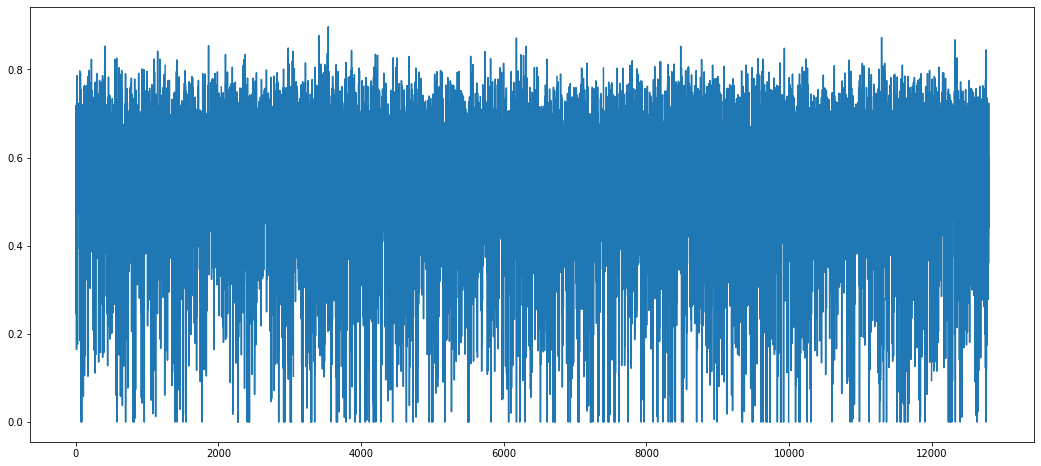

In [182]:
plt.figure(figsize=(18,8))
plt.plot(iou)